"""
# Cuaderno Extendido: Teoría y Ejemplos en IA Sub-Simbólica

Este cuaderno reúne de manera detallada los fundamentos teóricos y prácticos de varios temas clave en IA sub-simbólica. Se abordan:
- Distribuciones Gaussianas (unidimensional y multivariante)
- Reconocimiento de Formas y Extracción de Características
- Estimación no paramétrica de densidades: método de Ventana de Parzen y k-Nearest Neighbors (k-NN)
- Estimación paramétrica de densidades (máxima verosimilitud)
- Uso de redes neuronales para estimar densidades (Parzen Neural Networks – PNN)
- Fundamentos de las redes neuronales artificiales (ANN)
- Clasificadores bayesianos y toma de decisiones

Cada sección contiene la teoría necesaria, ejemplos de código en Python y comentarios que explican la importancia y aplicación de cada concepto.
"""

# %% [markdown]
"""
## 1. Distribuciones Gaussianas y sus Propiedades

Las distribuciones gaussianas (o normales) son esenciales en estadística y en el procesamiento de señales.

### Teoría

**Distribución Normal Unidimensional:**

La función de densidad de probabilidad (pdf) de una variable \(X\) con distribución normal es:

\[
p(x) = \frac{1}{\sigma \sqrt{2\pi}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)
\]

donde \(\mu\) es la media y \(\sigma^2\) es la varianza.

**Distribución Normal Multivariante:**

Para un vector \(x \in \mathbb{R}^d\), la pdf es:

\[
p(x) = \frac{1}{\sqrt{(2\pi)^d |\Sigma|}} \exp\left(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\right)
\]

donde \(\mu\) es el vector de medias y \(\Sigma\) la matriz de covarianza. Los contornos de nivel son elipses (o hiperelipsoides) que indican la variabilidad y correlación de los datos.

### Importancia

Estas distribuciones permiten modelar la incertidumbre y son la base para muchos métodos de clasificación y regresión. Por ejemplo, en reconocimiento de patrones se usan para definir distancias (como la de Mahalanobis) que tienen en cuenta la correlación entre variables.
"""

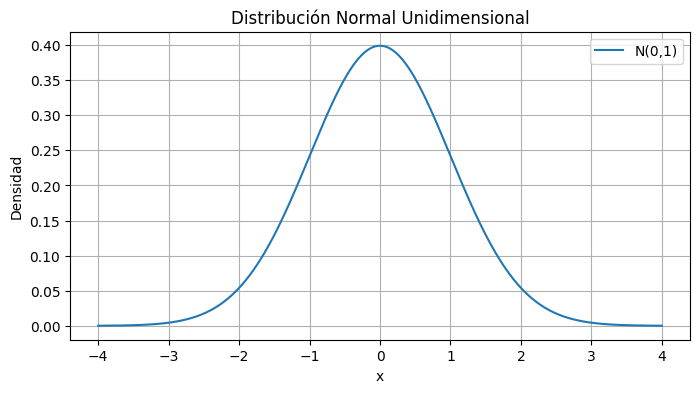

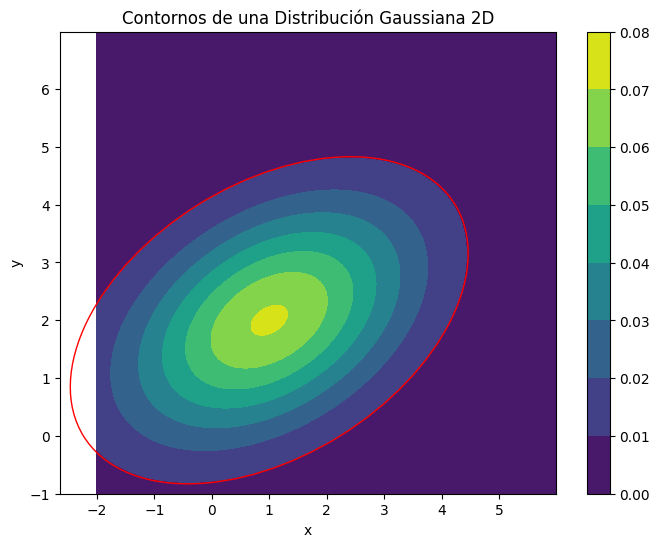

In [9]:
# %% [code]
import numpy as np
import matplotlib.pyplot as plt

# Ejemplo 1: Visualización de una distribución normal unidimensional
mu = 0
sigma = 1
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
pdf = (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-((x-mu)**2)/(2*sigma**2))

plt.figure(figsize=(8, 4))
plt.plot(x, pdf, label='N(0,1)')
plt.title('Distribución Normal Unidimensional')
plt.xlabel('x')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True)
plt.show()
# Fin del Ejemplo 1

# %% [markdown]
"""
### Ejemplo 2: Contornos de una Distribución Gaussiana Multivariante (2D)

En 2D, los contornos de la densidad son elipses que dependen de la matriz de covarianza. Este ejemplo ilustra cómo se calculan y se grafican estas elipses.
"""

# %% [code]
from matplotlib.patches import Ellipse

def plot_gaussian_contours(mu, Sigma, ax, n_std=2.0, facecolor='none', **kwargs):
    # Calcula autovalores y autovectores
    vals, vecs = np.linalg.eigh(Sigma)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # Ángulo de rotación
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Ancho y alto de la elipse
    width, height = 2 * n_std * np.sqrt(vals)
    ellip = Ellipse(xy=mu, width=width, height=height, angle=theta, facecolor=facecolor, **kwargs)
    ax.add_patch(ellip)
    return ellip

# Parámetros para la gaussiana 2D
mu2d = np.array([1, 2])
Sigma2d = np.array([[3, 1], [1, 2]])

x, y = np.mgrid[-2:6:.01, -1:7:.01]
pos = np.dstack((x, y))

def multivariate_gaussian(pos, mu, Sigma):
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)

    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
    return np.exp(-fac/2) / N

Z = multivariate_gaussian(pos, mu2d, Sigma2d)

fig, ax = plt.subplots(figsize=(8, 6))
cf = ax.contourf(x, y, Z, cmap='viridis')
plt.colorbar(cf)
plot_gaussian_contours(mu2d, Sigma2d, ax, n_std=2, edgecolor='red')
ax.set_title('Contornos de una Distribución Gaussiana 2D')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()
# Fin del Ejemplo 2


"""
## 2. Reconocimiento de Formas y Extracción de Características

El reconocimiento de patrones se basa en transformar señales del mundo real en vectores de características que luego se usan para clasificar o identificar objetos.

### Teoría

El proceso general consta de:
1. **Percepción:** Capturar el estímulo (imagen, sonido, etc.) y digitalizarlo.
2. **Extracción de Características:** Procesar los datos para extraer información relevante (por ejemplo, contornos, píxeles, etc.).
3. **Clasificación:** Utilizar un clasificador (como redes neuronales) para asignar la entrada a una clase.

### Importancia

La calidad de las características extraídas es crucial, ya que influye directamente en la capacidad del sistema para clasificar correctamente los patrones. Características bien diseñadas reducen la complejidad del modelo y mejoran la precisión.

### Ejemplo

Se simula la extracción de una característica simple (por ejemplo, la media de los valores) a partir de datos sintéticos para dos clases.
"""

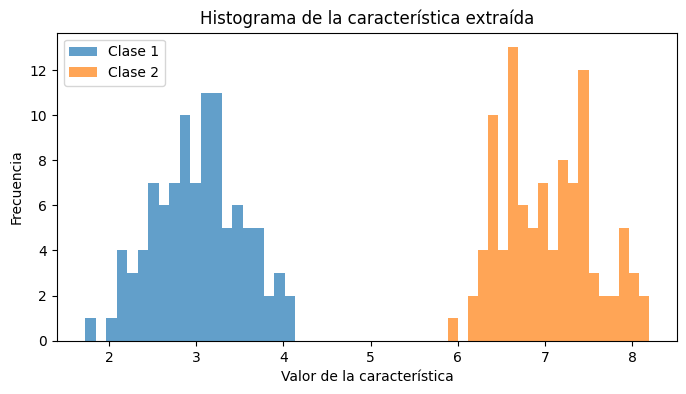

In [3]:
np.random.seed(0)
n_samples = 100

# Simulamos dos clases con diferentes medias
features_class1 = np.random.normal(loc=3, scale=0.5, size=(n_samples, 1))
features_class2 = np.random.normal(loc=7, scale=0.5, size=(n_samples, 1))

# Etiquetas
labels_class1 = np.zeros((n_samples,))
labels_class2 = np.ones((n_samples,))

# Unimos los datos
X_features = np.vstack((features_class1, features_class2))
y_labels = np.hstack((labels_class1, labels_class2))

plt.figure(figsize=(8,4))
plt.hist(features_class1, bins=20, alpha=0.7, label='Clase 1')
plt.hist(features_class2, bins=20, alpha=0.7, label='Clase 2')
plt.title('Histograma de la característica extraída')
plt.xlabel('Valor de la característica')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()
# Fin del ejemplo de extracción de características

"""
## 3. Estimación No Paramétrica de Densidades: Ventana de Parzen

La estimación de densidad no paramétrica permite calcular \(p(x)\) directamente a partir de los datos sin asumir una forma fija para la distribución.

### Teoría

El método de la Ventana de Parzen consiste en definir un kernel (por ejemplo, una ventana rectangular) y estimar:

\[
p(x_0) \approx \frac{k}{n \cdot h},
\]

donde \(k\) es el número de muestras que caen dentro de la ventana centrada en \(x_0\), \(n\) es el total de muestras y \(h\) es el ancho de la ventana (volumen en 1D).

### Importancia

Este método es muy flexible porque no impone una forma predefinida a la pdf; sin embargo, su desempeño depende de la elección del parámetro \(h\).

### Ejemplo

Implementamos un estimador de densidad en 1D usando un kernel rectangular.
"""


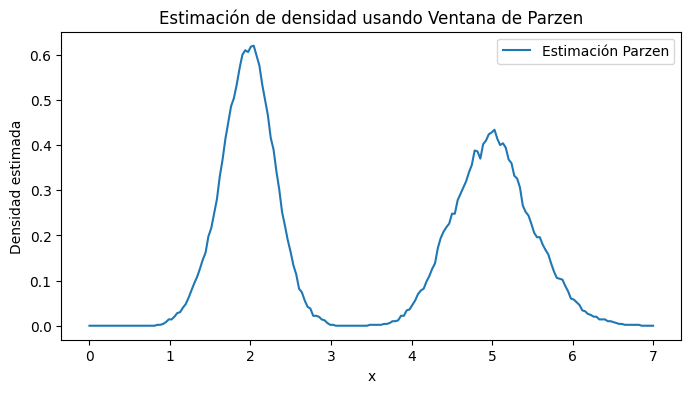

In [4]:
def parzen_window_estimator(x0, data, h):
    # Ventana rectangular de ancho h (volumen en 1D es h)
    n = len(data)
    kernel_values = np.where(np.abs(data - x0) <= h/2, 1, 0)
    return np.sum(kernel_values) / (n * h)

# Generamos datos sintéticos: mezcla de dos distribuciones
data_parzen = np.concatenate((np.random.normal(2, 0.3, 500), np.random.normal(5, 0.5, 500)))
x_vals = np.linspace(0, 7, 200)
density_est_parzen = [parzen_window_estimator(x, data_parzen, h=0.5) for x in x_vals]

plt.figure(figsize=(8,4))
plt.plot(x_vals, density_est_parzen, label='Estimación Parzen')
plt.title('Estimación de densidad usando Ventana de Parzen')
plt.xlabel('x')
plt.ylabel('Densidad estimada')
plt.legend()
plt.show()

## 4. Estimación No Paramétrica de Densidades: k-Nearest Neighbors (k-NN)

El método k-NN fija un número de vecinos \(k\) y determina el volumen \(V\) mínimo que contiene dichos vecinos. La densidad se estima como:

\[
p(x_0) \approx \frac{k}{n \cdot V}.
\]

### Teoría

En 1D, se ordenan las distancias de \(x_0\) a cada punto; se toma la k-ésima distancia y se define el volumen como el doble de esa distancia (por ser un intervalo).

### Importancia

El k-NN adapta el tamaño de la ventana a la densidad local, lo que puede mejorar la precisión en regiones de alta variabilidad.

### Ejemplo

Implementamos un estimador k-NN en 1D.
"""

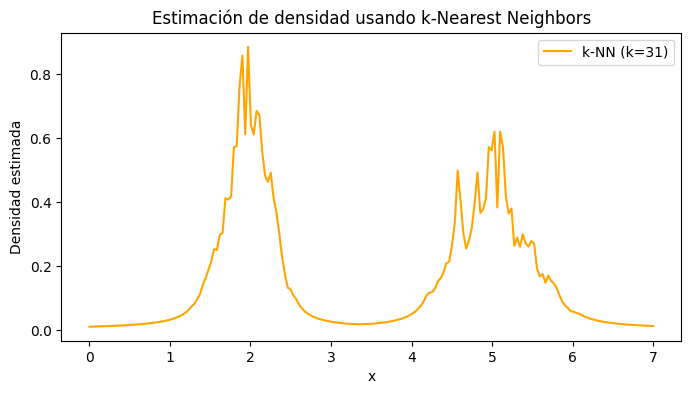

In [5]:
# %% [code]
def knn_density_estimator(x0, data, k):
    # Calcula las distancias absolutas desde x0 a todos los puntos
    distances = np.abs(data - x0)
    sorted_distances = np.sort(distances)
    # En 1D, el 'volumen' es 2 veces la k-ésima distancia
    radius = sorted_distances[k-1]
    V = 2 * radius
    return k / (len(data) * V)

k_val = int(np.sqrt(len(data_parzen)))
density_est_knn = [knn_density_estimator(x, data_parzen, k_val) for x in x_vals]

plt.figure(figsize=(8,4))
plt.plot(x_vals, density_est_knn, label=f'k-NN (k={k_val})', color='orange')
plt.title('Estimación de densidad usando k-Nearest Neighbors')
plt.xlabel('x')
plt.ylabel('Densidad estimada')
plt.legend()
plt.show()
# Fin del ejemplo k-NN

## 5. Estimación Paramétrica de Densidades

En el enfoque paramétrico se asume que la forma de la pdf es conocida (por ejemplo, gaussiana) y se estiman sus parámetros mediante el método de máxima verosimilitud (ML).

### Teoría

Para una distribución normal unidimensional, la función de verosimilitud para \(n\) muestras \(y_1, \dots, y_n\) es:

\[
L(\mu,\sigma^2) = \prod_{k=1}^{n} \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left(-\frac{(y_k-\mu)^2}{2\sigma^2}\right)
\]

Al tomar el logaritmo y derivar, se obtiene que el estimador de ML para \(\mu\) es la media muestral y para \(\sigma^2\) es la varianza muestral.

### Importancia

Estos estimadores son la base de los modelos paramétricos, ofreciendo soluciones cerradas y óptimas cuando se cumple la suposición de forma fija de la pdf.

### Ejemplo

Generamos datos sintéticos de una normal y calculamos la media y varianza muestrales.
"""

In [6]:
# %% [code]
# Generamos datos sintéticos de una distribución normal
data_gauss = np.random.normal(loc=5, scale=2, size=1000)

# Estimación de parámetros (MLE)
mu_mle = np.mean(data_gauss)
sigma2_mle = np.mean((data_gauss - mu_mle)**2)

print(f"Media estimada (MLE): {mu_mle:.3f}")
print(f"Varianza estimada (MLE): {sigma2_mle:.3f}")
# Fin del ejemplo de estimación paramétrica

Media estimada (MLE): 4.974
Varianza estimada (MLE): 3.878


## 6. Redes Neuronales para Estimación de Densidades (PNN)

La idea es entrenar un perceptrón multicapa (MLP) para aproximar la función de densidad \(p(x)\). Se generan objetivos utilizando el método de Parzen y se entrena el MLP para que aprenda la relación \(x \to p(x)\).

### Teoría

1. Se generan datos \(x_i\) de la distribución desconocida.
2. Para cada \(x_i\), se estima un valor objetivo \(y_i\) usando la Ventana de Parzen.
3. Se entrena un MLP con los pares \((x_i, y_i)\) para aproximar la pdf.

### Importancia

Este enfoque genera un modelo compacto que generaliza a nuevos datos, a diferencia de los métodos basados en memoria (como Parzen o k-NN), y reduce la complejidad en la fase de test.

### Ejemplo

Entrenamos un MLP para estimar la densidad de una distribución exponencial, comparándolo con el método de Parzen.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


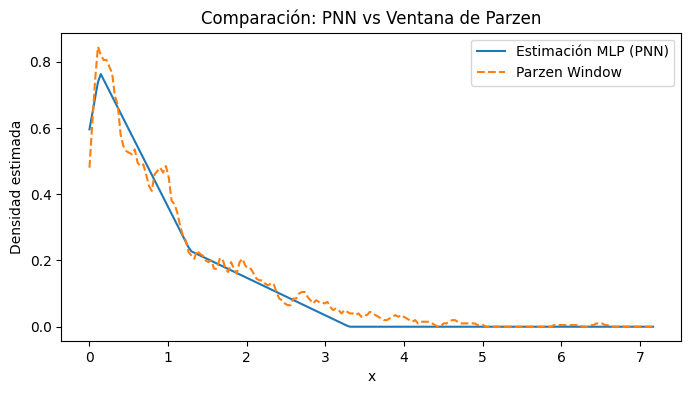

In [13]:
# %% [code]
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Generamos datos de una distribución exponencial
n_samples = 1000
data_exp = np.random.exponential(scale=1.0, size=n_samples)

# Usamos el método Parzen para generar targets
h_value = 0.2
X_train = data_exp.reshape(-1, 1)
y_train = np.array([parzen_window_estimator(x, data_exp, h_value) for x in data_exp])

# Definimos un MLP sencillo
model_pnn = Sequential([
    Dense(16, activation='relu', input_shape=(1,)),
    Dense(16, activation='relu'),
    Dense(1, activation='relu')  # Forzamos salida no negativa
])

model_pnn.compile(optimizer='adam', loss='mse')

# Entrenamos el MLP
history_pnn = model_pnn.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Evaluamos la densidad estimada en un rango
x_test = np.linspace(0, np.max(data_exp)*1.1, 200).reshape(-1, 1)
y_pred = model_pnn.predict(x_test)

plt.figure(figsize=(8,4))
plt.plot(x_test, y_pred, label='Estimación MLP (PNN)')
parzen_vals = [parzen_window_estimator(x, data_exp, h_value) for x in x_test.flatten()]
plt.plot(x_test, parzen_vals, '--', label='Parzen Window')
plt.title('Comparación: PNN vs Ventana de Parzen')
plt.xlabel('x')
plt.ylabel('Densidad estimada')
plt.legend()
plt.show()
# Fin del ejemplo PNN

+"""
## 7. Fundamentos de las Redes Neuronales Artificiales (ANN)

Las redes neuronales son sistemas inspirados en el cerebro humano. Sus componentes básicos son:

- **Arquitectura:** Compuesta por capas (entrada, ocultas y salida) conectadas por pesos.
- **Dinámica:** Propagación de la señal mediante funciones de activación en cada neurona (por ejemplo, ReLU, sigmoide).
- **Aprendizaje:** Ajuste de los pesos mediante algoritmos de retropropagación para minimizar una función de error.

### Importancia

Comprender estos fundamentos es vital para diseñar y entrenar modelos capaces de aproximar funciones complejas, realizar clasificación, regresión y extraer características de los datos.

### Ejemplo

Entrenamos un MLP sencillo en el conjunto de datos Iris para clasificar flores.
"""

In [27]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Cargamos el conjunto de datos Iris
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Escalamos las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_iris)

# Convertimos las etiquetas a one-hot
y_onehot = to_categorical(y_iris)

# Dividimos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42)

# Definimos un MLP sencillo
model_iris = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

model_iris.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_iris = model_iris.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

loss, acc = model_iris.evaluate(X_test, y_test, verbose=0)
print(f"Precisión en Iris: {acc*100:.2f}%")
# Fin del ejemplo Iris

ModuleNotFoundError: No module named 'sklearn'

"""
## 8. Clasificadores Bayesianos y Toma de Decisiones

La teoría bayesiana para la clasificación se basa en el Teorema de Bayes:

\[
P(\omega_i|x) = \frac{p(x|\omega_i)P(\omega_i)}{p(x)}
\]

La regla de decisión de Bayes asigna el patrón \(x\) a la clase que maximice \(P(\omega_i|x)\). Si se asume que \(p(x|\omega_i)\) es gaussiana, se pueden derivar funciones discriminantes, que en ciertos casos (como con covarianza compartida) resultan en clasificadores lineales.

### Importancia

La clasificación bayesiana es óptima en el sentido de minimizar la probabilidad de error, por lo que es la base teórica para muchos sistemas de clasificación.

### Ejemplo

Generamos datos sintéticos 2D para dos clases y calculamos la frontera de decisión usando discriminantes basados en distribuciones gaussianas con covarianza compartida.
"""

C:\Users\Ricardo\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
C:\Users\Ricardo\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\colors.py:2295: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


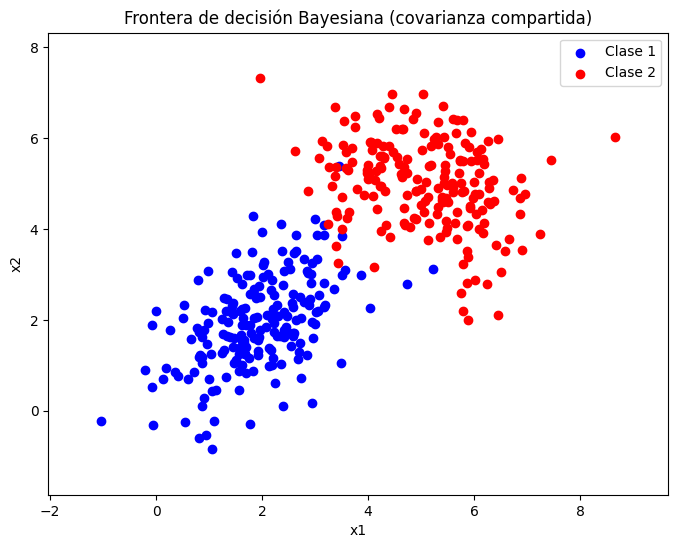

In [10]:
# %% [code]
from matplotlib.colors import ListedColormap

np.random.seed(1)
n_points = 200
mean1 = [2, 2]
cov1 = [[1, 0.5], [0.5, 1]]
mean2 = [5, 5]
cov2 = [[1, -0.3], [-0.3, 1]]

X1 = np.random.multivariate_normal(mean1, cov1, n_points)
X2 = np.random.multivariate_normal(mean2, cov2, n_points)
X_bayes = np.vstack((X1, X2))
y_bayes = np.hstack((np.zeros(n_points), np.ones(n_points)))

# Estimación de parámetros para cada clase
mu1_est = np.mean(X1, axis=0)
mu2_est = np.mean(X2, axis=0)
Sigma1_est = np.cov(X1, rowvar=False)
Sigma2_est = np.cov(X2, rowvar=False)

# Asumimos covarianza compartida (promedio)
Sigma_shared = (Sigma1_est + Sigma2_est) / 2
Sigma_inv = np.linalg.inv(Sigma_shared)

def g(x, mu, Sigma_inv, prior):
    diff = x - mu
    return -0.5 * np.dot(np.dot(diff, Sigma_inv), diff.T) + np.log(prior)

prior1 = prior2 = 0.5

x_min, x_max = X_bayes[:, 0].min() - 1, X_bayes[:, 0].max() + 1
y_min, y_max = X_bayes[:, 1].min() - 1, X_bayes[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]

g1 = np.array([g(x, mu1_est, Sigma_inv, prior1) for x in grid])
g2 = np.array([g(x, mu2_est, Sigma_inv, prior2) for x in grid])

decision = (g1 - g2).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, decision, levels=[-np.inf, 0, np.inf], alpha=0.3, cmap=ListedColormap(['blue', 'red']))
plt.scatter(X1[:,0], X1[:,1], c='blue', label='Clase 1')
plt.scatter(X2[:,0], X2[:,1], c='red', label='Clase 2')
plt.title('Frontera de decisión Bayesiana (covarianza compartida)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()
# Fin del ejemplo de clasificadores bayesianos